In [1]:
# This is for testing only.
%load_ext autoreload
%autoreload 2

In [62]:
# Load modules.
import pickle
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple

import emcee

from astropy import units as u
from astropy import constants as ac
from chainconsumer import ChainConsumer

from rrlpy.rrl import RRLs
from rrlpy.synth import layers
from rrlpy.departure import BnBeta
from rrlpy.continuum import PowerLaw

In [43]:
# Set up departure coefficients.
# You'd have to set the path and the filenames.
path = "/home/scratch/psalas/projects/GDIGS-Low/analysis/simulations/layered_emission/"
bn = np.load(f'{path}/bn_hrrl.npy')
beta = np.load(f'{path}/beta_hrrl.npy')
bn_head = pickle.load(open(f'{path}/bn_hrrl_head.p', "rb" ))
bnbeta = BnBeta(bn[0,0,:], bn[:,-1,:], bn_head["Te_v"]*u.K, bn_head["ne_v"]*u.cm**-3, None, beta=beta[:,:,0])

In [44]:
# Interpolate the departure coefficients.
# You can ignore the warning.
bnbeta_i = bnbeta.interpolate()

/home/sandboxes/psalas/RRLpy/rrlpy/src/rrlpy/departure/bnbeta.py:87: UserWarning: Will use all n values.
  warnings.warn("Will use all n values.")


In [45]:
# Set up lines.
rrls = RRLs(np.array([104, 167, 203, 268]), # Principal quantum numbers.
            ["H", "H", "H", "H"], # Element.
            ["alpha"]*4, # Transition.
            np.array([1, 1, 1, 1]), # Net charge, Z.
            )

In [46]:
# Set up radiation fields.
background = PowerLaw(0.14*33.*u.K, 1*u.GHz, -2.2)
medium = PowerLaw(0.*u.K, 1*u.GHz, -2.6)

In [47]:
# X-axis for the spectra.
x_axis = np.arange(-300, 300, 1) * u.km/u.s

In [48]:
# Define a gas layer.
layer = layers.Layer(3*u.cm**-3, 7000*u.K, 220*u.pc, 1*u.km/u.s,
                     bnbeta_i, rrls, background, medium,
                     x_axis=x_axis)

In [49]:
# Compute the line emission from the layer.
# We will use this as our "observed" data, or mock data.
layer.compute()

In [57]:
# Define functions to be used during the fitting.

param = namedtuple('Param', ['name', 'value', 'min', 'max'])


def set_params(theta, params=None):
    """
    Updates the values of the parameter vector.
    """
    for p, v in zip(params.keys(), theta):
        params[p] = params[p]._replace(value=v)
    return params


def log_prior(params):
    """
    Priors.
    """
    # Check the bounds of the parameters
    lnp = 0
    for p in params.values():
        if p.value <= p.min or p.value >= p.max:
            return -np.inf
            
    return lnp


def synth_spec(params, 
               vrms, bnbeta, rrls, background, medium, x_axis):
    """
    Generates the RRL spectra given the current vector of parameters values.
    """

    te_ = 7000*u.K # This fixes the temperature.
    # This will only fit for the electron density and
    # path length.
    ne_ = 10**params["ne"].value * u.cm**-3
    ds_ = 10**params["ds"].value * u.pc

    layer = layers.Layer(ne_, te_, ds_, vrms,
                         bnbeta, rrls, background, medium,
                         x_axis=x_axis)
    layer.compute()
    
    return layer.tl_x


def log_likelihood(params, y, yerr, **kwargs):
    """
    Log likelihood assuming Gaussian distribution.
    """

    ymod = synth_spec(params, **kwargs)

    return -0.5*np.sum( np.power((ymod - y)/yerr, 2.) )


def log_prob(theta, y, yerr, params, **kwargs):
    """
    Function for `emcee`.
    """

    params = set_params(theta, params=params)
    lp = log_prior(params)

    return lp + log_likelihood(params, y, yerr, **kwargs)

In [58]:
# Set up parameters and their bounds.
params = {}
params["ne"] = param(name="ne", value=1, min=np.log10(bnbeta_i.ne.min().value), max=np.log10(bnbeta_i.ne.max().value))
params["ds"] = param(name="ds", value=2, min=-1, max=3)

In [60]:
# Setting up mcmc parameters.
nwalkers, ndims, nsteps = 20, len(params), 1000

# Setting up the starting positions using uniform PDFs.
cov = {'ne': 1, 'te': 1, 'em': 1, 'fbg': 1}
# pos = np.asarray([params[p] + np.random.randn(nwalkers) * cov[p] for p in params])
random_gen = np.random.default_rng()
pos = np.array([random_gen.uniform(p.min, p.max, nwalkers) for p in params.values()])
pos = pos.T

# Additional arguments needed to compute the RRL spectra.
# In this case we use the same as those of the mock spectra.
# For real data you'd have to provide guesses for `background`
# and `medium`, and make sure all the input data uses the same `x_axis`.
kwargs = {"vrms": 1*u.km/u.s, 
          "bnbeta": bnbeta_i, 
          "rrls": rrls, 
          "background": background, 
          "medium": medium, 
          "x_axis": x_axis}

# Add some noise to the mock data.
noise = np.random.normal(loc=0.0, scale=10, size=layer.tl_x.shape) * u.mK

# Run the emcee sampler. 
# With 1000 `steps` and 20 `walkers` this takes ~15 minutes.
sampler = emcee.EnsembleSampler(nwalkers, ndims, log_prob, args=(layer.tl_x, noise, params),
                                kwargs=kwargs)
sampler.run_mcmc(pos, 1000, progress=True);

  0%|▏                                                                                                                                                                         | 1/1000 [00:00<14:28,  1.15it/s]/home/sandboxes/psalas/RRLpy/py3.9-venv/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in scalar multiply
  return lambda val: scale * _condition_arg(val)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:43<00:00,  1.13it/s]


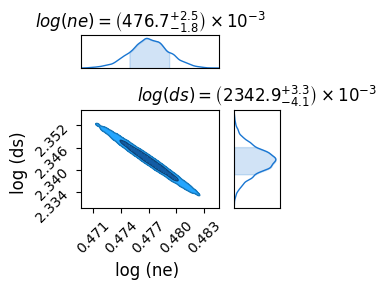

In [63]:
# Extract the results from the sampler.
# The maximum likelihood values should match those of the gas layer we generated above.
flat_sample_A = sampler.get_chain(discard=sampler.iteration // 2, flat=True)
pars = ['log (' + l + ')' for l in list(params.keys())]
cA = ChainConsumer()
cA.add_chain(np.asarray(flat_sample_A), parameters=pars)
cA.plotter.plot()
# By default chainconsumer reports the 1 sigma intervals above and below the maximum likelihood value.
plt.tight_layout()

In [66]:
# Effectively, the best fit parameters match those of the input gas layer!
np.power(10, 0.48), np.power(10, 2.346)

(3.019951720402016, 221.81964198002194)